# Rubisco data

In [2]:
%pylab inline
import h5py, os
import spimage, condor
from matplotlib.colors import LogNorm
import scipy.optimize
import scipy.constants

Populating the interactive namespace from numpy and matplotlib


/Users/max.hantke/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading data from files

In [3]:
directory = '/Users/max.hantke/data/xfel'

In [4]:
filename_dark   = os.path.join(directory, 'amol3416_r0257_ol3_small.h5')
filename_bg     = os.path.join(directory, 'amol3416_r0256_ol3_small.h5')
filename_sample = os.path.join(directory, 'amol3416_r0252_ol3_small.h5')
filename_buffer = os.path.join(directory, 'amol3416_r0203_ol3_small.h5')

In [12]:
N = 15000
with h5py.File(filename_sample, 'r') as f:
    imin = 2500
    print(f['/entry_1/data_1/data'].shape[0])
    data_sample = asarray(f['/entry_1/data_1/data'][imin:imin+N])
    mask_sample = asarray(f['/entry_1/data_1/mask'][imin:imin+N]) == False
    gmd_sample = asarray(f['/entry_1/experiment/pulse_energy'][imin:imin+N])
    #data_sample = asarray(f['/entry_1/data_1/data'][:])
    #mask_sample = asarray(f['/entry_1/data_1/mask'][:]) == False
    #gmd_sample = asarray(f['/entry_1/experiment/pulse_energy'][:])
    n_sample = data_sample.shape[0]
    n_sample_fel_on = (gmd_sample > 1).sum()
    print("Sample: %i (%i)" % (n_sample, n_sample_fel_on))
with h5py.File(filename_buffer, 'r') as f:
    imin = 0
    print(f['/entry_1/data_1/data'].shape[0])
    data_buffer = asarray(f['/entry_1/data_1/data'])[imin:imin+N]
    mask_buffer = asarray(f['/entry_1/data_1/mask'][imin:imin+N]) == False
    #mask_buffer = asarray(f['/entry_1/data_1/mask']) == False
    gmd_buffer = asarray(f['/entry_1/experiment/pulse_energy'][imin:imin+N])
    #gmd_buffer = asarray(f['/entry_1/experiment/pulse_energy'])
    n_buffer = data_buffer.shape[0]
    n_buffer_fel_on = (gmd_buffer > 1).sum()
    print("Buffer: %i (%i)" % (n_buffer, n_buffer_fel_on))
with h5py.File(filename_bg, 'r') as f:
    imin = 0
    print(f['/entry_1/data_1/data'].shape[0])
    data_bg = asarray(f['/entry_1/data_1/data'][imin:imin+N])
    mask_bg = asarray(f['/entry_1/data_1/mask'][imin:imin+N]) == False
    gmd_bg = asarray(f['/entry_1/experiment/pulse_energy'][imin:imin+N])
    n_bg = data_bg.shape[0]
    n_bg_fel_on = (gmd_bg > 1).sum()
    print("Bg: %i (%i)" % (n_bg, n_bg_fel_on))
with h5py.File(filename_dark, 'r') as f:
    print(f['/entry_1/data_1/data'].shape[0])
    data_dark = asarray(f['/entry_1/data_1/data'][-N:])
    mask_dark = asarray(f['/entry_1/data_1/mask'][-N:]) == False
    n_dark = data_dark.shape[0]
    print("Dark: %i" % (n_dark))
    
Ny, Nx = data_dark.shape[1], data_dark.shape[2]



124489
Sample: 15000 (14361)
17314
Buffer: 15000 (14343)
24659
Bg: 15000 (14367)
6993
Dark: 6993


Masking out odd pixels and pixels that do not follow Poissonian distribution

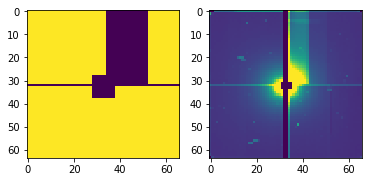

In [13]:
fig, axs = subplots(1, 2)
mask_odd = np.ones(shape=data_bg[0].shape, dtype=np.bool)
mask_odd[:32,34:34+18] = False
mask_odd[32,:] = False
mask_odd[28:38,28:38] = False
axs[0].imshow(mask_odd)
axs[1].imshow(data_bg.std(axis=0), vmax=10)

/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in divide


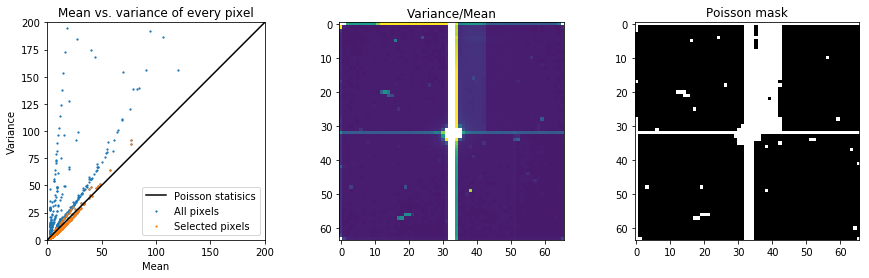

In [14]:
data_bg_var = data_bg[gmd_bg>0.5,:,:].var(axis=0)
data_bg_mean = data_bg[gmd_bg>0.5,:,:].mean(axis=0)
mask_poisson = abs(1-data_bg_var/data_bg_mean) < 0.3

fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 4))
ax1.set_title('Mean vs. variance of every pixel')
ax1.scatter(data_bg_mean.ravel(), data_bg_var.ravel(), s=1.5, label='All pixels')
ax1.scatter(data_bg_mean[mask_poisson].ravel(), data_bg_var[mask_poisson].ravel(), s=1.5, label='Selected pixels')
ax1.plot([0, 200], [0, 200], color='k', label='Poisson statisics')
ax1.legend()
ax1.set_ylabel('Variance')
ax1.set_xlabel('Mean')
ax1.set_ylim(0, 200)
ax1.set_xlim(0, 200)
ax1.set_aspect(1.)
ax2.set_title('Variance/Mean')
ax2.imshow(data_bg_var/data_bg_mean, vmin=0, vmax=10)
ax3.set_title('Poisson mask')
ax3.imshow(mask_poisson, vmin=0, vmax=1, cmap='binary')


Apply masks

In [15]:
mask0 = mask_poisson*mask_odd
mask_sample *= mask0
mask_buffer *= mask0
mask_bg *= mask0
mask_dark *= mask0

In [16]:
#imgs_sample *= mask_sample
#data_buffer *= mask_buffer
#data_bg     *= mask_bg
#data_dark   *= mask_dark
bg_sample = median(data_sample[gmd_sample>1., :, :], axis=0)
bg_buffer = median(data_buffer[gmd_buffer>1., :, :], axis=0)
bg_bg     = median(data_bg[gmd_bg>1., :, :], axis=0)
bg_dark   = median(data_dark[:, :, :], axis=0)

In [17]:
diff_sample = (data_sample-bg_sample)*mask0
diff_buffer = (data_buffer-bg_buffer)*mask0
diff_bg     = (data_bg-bg_bg)*mask0
diff_dark   = (data_dark-bg_dark)*mask0

In [18]:
cx = 32
cy = 32
X, Y = meshgrid(arange(Nx), arange(Ny))
X -= cx
Y -= cy
ascore_weights = lambda diff: diff
ascore = lambda diff: sqrt((ascore_weights(diff)*X).sum(axis=1).sum(axis=1)**2 +
                           (ascore_weights(diff)*Y).sum(axis=1).sum(axis=1)**2)
ascore_sample = ascore(diff_sample)
ascore_sample[isinf(ascore_sample)] = 0.
ascore_buffer = ascore(diff_buffer)
ascore_buffer[isinf(ascore_buffer)] = 0.
ascore_bg     = ascore(diff_bg)
ascore_bg[isinf(ascore_bg)] = 0.
ascore_dark   = ascore(diff_dark)
ascore_dark[isinf(ascore_dark)] = 0.

In [19]:
R = sqrt(X**2+Y**2)
rmax = lambda diff: R.ravel()[diff.reshape(diff.shape[0], Nx*Ny).argmax(axis=1)]
rmax_sample = rmax(diff_sample)
rmax_buffer = rmax(diff_buffer)
rmax_bg = rmax(diff_bg)
rmax_dark = rmax(diff_dark)

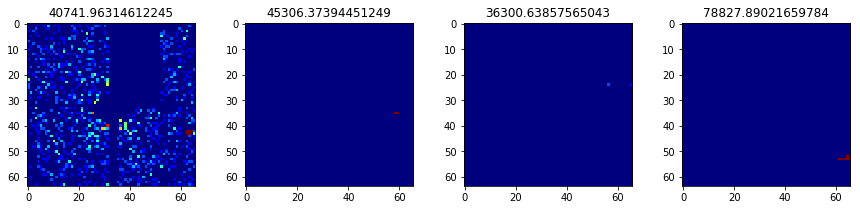

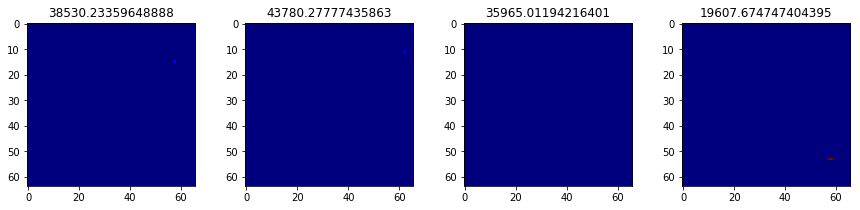

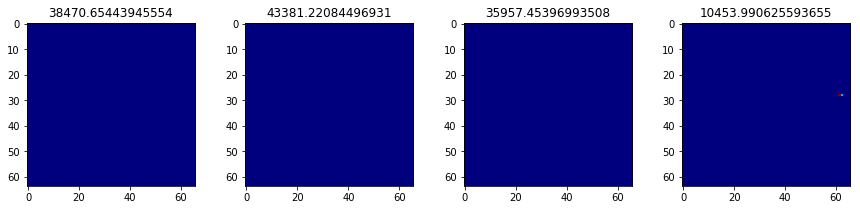

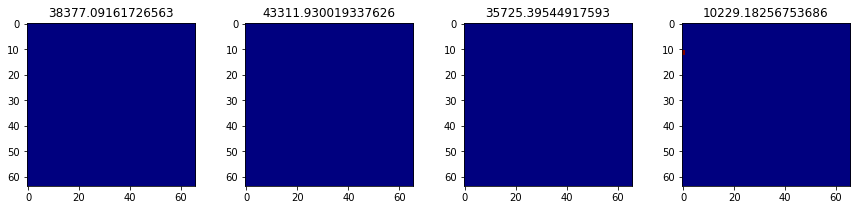

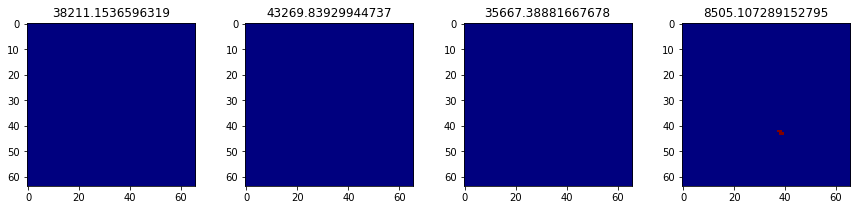

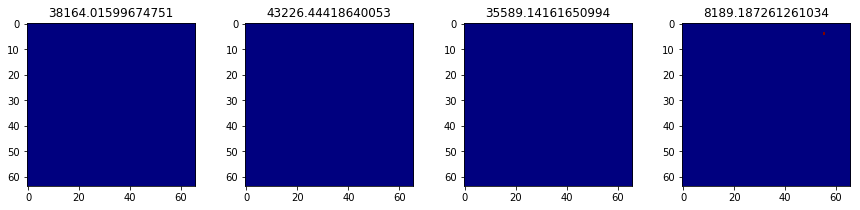

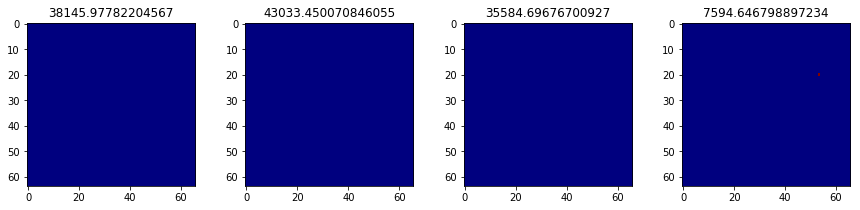

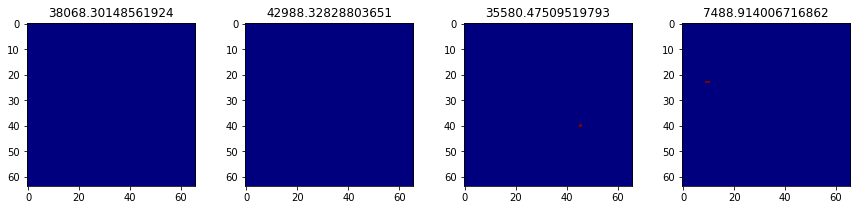

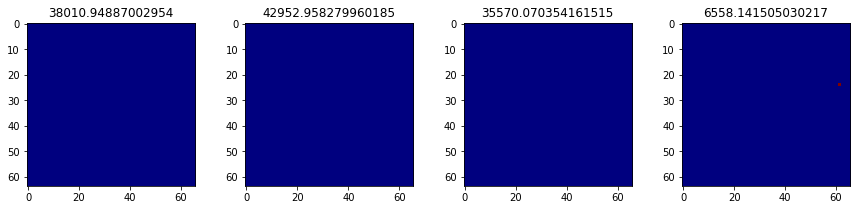

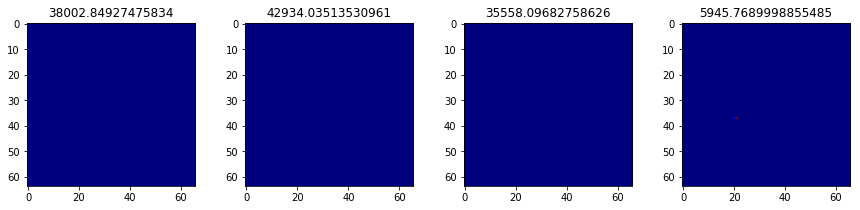

In [20]:
ascore_sample_list = ascore_sample.argsort()[::-1]
ascore_buffer_list = ascore_buffer.argsort()[::-1]
ascore_bg_list = ascore_bg.argsort()[::-1]
ascore_dark_list = ascore_dark.argsort()[::-1]

for i in arange(10):
    fig, axs = subplots(1, 4, figsize=(15, 3))
    axs[0].set_title(ascore_sample[ascore_sample_list[i]])
    axs[0].imshow(diff_sample[ascore_sample_list[i]], cmap='jet', vmin=0, vmax=10)
    axs[1].set_title(ascore_buffer[ascore_buffer_list[i]])
    axs[1].imshow(diff_buffer[ascore_buffer_list[i]], cmap='jet', vmin=0, vmax=10)
    axs[2].set_title(ascore_bg[ascore_bg_list[i]])
    axs[2].imshow(diff_bg[ascore_bg_list[i]], cmap='jet', vmin=0, vmax=10)
    axs[3].set_title(ascore_dark[ascore_dark_list[i]])
    axs[3].imshow(diff_dark[ascore_dark_list[i]], cmap='jet', vmin=0, vmax=10)

Count number of photons per pattern

In [21]:
nph_dark   = (data_dark*mask0).sum(axis=1).sum(axis=1)
nph_bg     = (data_bg*mask0).sum(axis=1).sum(axis=1)
nph_sample = (data_sample*mask0).sum(axis=1).sum(axis=1)
nph_buffer = (data_buffer*mask0).sum(axis=1).sum(axis=1)

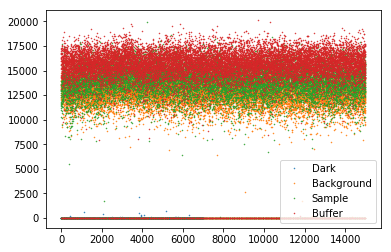

In [22]:
plot(nph_dark, '.', label='Dark', ms=1.)
plot(nph_bg, '.', label='Background', ms=1.)
plot(nph_sample, '.', label='Sample', ms=1.)
plot(nph_buffer, '.', label='Buffer', ms=1.)
#plot(nph_dark, '.', label='Dark')
legend()

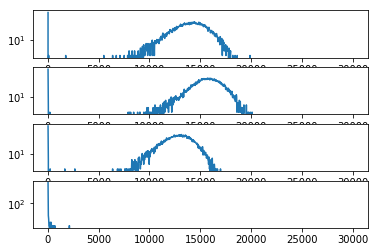

In [23]:
fig, axs = subplots(4, 1)
H_dark, s = histogram(nph_dark, 1000, range=(0, 30000))
H_bg, s = histogram(nph_bg, 1000, range=(0, 30000))
H_sample, s = histogram(nph_sample, 1000, range=(0, 30000))
H_buffer, s = histogram(nph_buffer, 1000, range=(0, 30000))
sc = s[:-1] + (s[1]-s[0])/2.
axs[3].semilogy(sc, H_dark)
axs[2].semilogy(sc, H_bg)
axs[1].semilogy(sc, H_buffer)
axs[0].semilogy(sc, H_sample)

Look at data

In [24]:
#i_strong = (diff_sample*mask0>5).sum(axis=1).sum(axis=1).argsort()[::-1]
#i_asymm  = (ascore).argsort()[::-1]

In [25]:
#imshow(diff_sample[i_strong[0]], norm=LogNorm(vmin=0.1, vmax=1000))

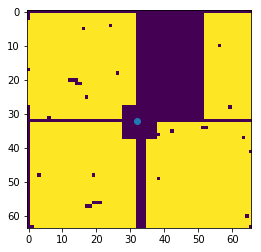

In [26]:
i = nph_sample.argmax()
imshow(mask_sample[i])
scatter([32], [32])

Fit data to sphere model

In [38]:
wavelength = condor.utils.photon.Photon(energy_eV=800.).get_wavelength()
pixelsize = 75E-6 * 16
distance = 0.130
rpix, _ = spimage.radialMeanImage(img=data_sample[0], msk=mask_sample[0], cx=cx, cy=cy, output_r=True)
qpix = abs(np.asarray([condor.utils.scattering_vector.q_from_p(p=np.array([p*pixelsize, 0., distance]), wavelength=wavelength) for p in rpix]).sum(axis=1))
spix = qpix/(2*pi)

Ir_sphere = lambda K, diameter: condor.utils.sphere_diffraction.I_sphere_diffraction(K=K, q=qpix, r=diameter/2*1E-9)

# K = I_0 \left(\rho_e \frac{p}{D} r_0 V_r\right)^2
material = condor.utils.material.AtomDensityMaterial(material_type='protein')
r_0 = scipy.constants.value("classical electron radius")
rho_e = material.get_electron_density()
print(rho_e*1E-30)

I_from_K = lambda K, d: K/(rho_e*pixelsize/distance*r_0*4/3.*pi*(d/2.)**3)**2 
K_from_I = lambda I, d: I*(rho_e*pixelsize/distance*r_0*4/3.*pi*(d/2.)**3)**2
to_mJ_by_um2 = lambda I: I*1e3*(800*scipy.constants.elementary_charge)*1E-12
from_mJ_by_um2 = lambda I: I/(1e3*(800*scipy.constants.elementary_charge)*1E-12)

Ir_std    = spimage.radialMeanImage(img=sqrt(data_bg_var), msk=mask0, cx=cx, cy=cy)

def calculate_rmeans(data, mask, bg):
    Ir_bg     = spimage.radialMeanImage(img=bg, msk=mask0, cx=cx, cy=cy)
    Ir_data   = np.asarray([spimage.radialMeanImage(img=datai, msk=maski, cx=32, cy=32) for datai, maski in zip(data, mask)])
    return Ir_data, Ir_bg

def fit_sphere(I, weights, sel, K_guess, d_guess, o_guess, bootstrap=False):
    #err = lambda v: (((Ir_sphere(v[0], v[1])+v[2]-I)*Ir_bg)**2).sum()
    err = lambda v: (((Ir_sphere(v[0], v[1])+v[2]-I)/weights)**2)[sel].sum()
    if not bootstrap:
        v0 = (K_guess, d_guess, o_guess)
        res = scipy.optimize.minimize(err, v0)
        d_std = None
        I_std = None
    else:
        ress = []
        for _d_guess in linspace(2, 40, 20):
            v0 = (K_guess, _d_guess, o_guess)
            res = scipy.optimize.minimize(err, v0)
            ress.append(res)
        errs = np.asarray([res.fun for res in ress])
        ds   = np.asarray([res.x[1] for res in ress])
        Is   = np.asarray([res.x[0] for res in ress])
        res = ress[errs.argmin()]
        d_std = ds.std()
        I_std = Is.std()
    return res.x, res.fun, d_std, I_std

def fit_batch(data, mask, bg, do_plot=True):

    N_fit = len(data)
    goods_fit = np.zeros(N_fit, dtype=np.bool)
    ds_fit   = np.zeros(N_fit)
    Is_fit   = np.zeros(N_fit)
    ds_std   = np.zeros(N_fit)
    Is_std   = np.zeros(N_fit)

    nph = (data*mask).sum(axis=1).sum(axis=1)
    
    rmax = 20
    sel = rpix < rmax
    
    #i_list = (data*mask>20).sum(axis=1).sum(axis=1).argsort()[::-1]
    
    
    for i in range(0, len(data)):
        #i = i_list[k]

        Ir_data   = spimage.radialMeanImage(img=data[i], msk=mask[i], cx=cx, cy=cy)
        Ir_bg     = spimage.radialMeanImage(img=bg, msk=mask[i], cx=cx, cy=cy)
        Ir_std    = spimage.radialMeanImage(img=sqrt(data_bg_var), msk=mask[i], cx=cx, cy=cy)
        Ir_diff   = Ir_data - Ir_bg

        K_guess = Ir_diff.max()*1.3
        d_guess = 30.
        o_guess = 0.

        (K_fit, d_fit, o_fit), err_fit, ds_std[i], Is_std[i] = fit_sphere(Ir_diff, Ir_std, sel, K_guess, d_guess, o_guess, bootstrap=False)
        Ir_model  = Ir_sphere(K_fit, d_fit) + o_fit
        
        good = (abs(Ir_model - Ir_diff)[sel] <= 10*Ir_std[sel]).all() * ((Ir_diff > 4*Ir_std)[sel].sum() > sel.sum()/4.)
        
        goods_fit[i] = good
        ds_fit[i]   = abs(d_fit)
        Is_fit[i]   = to_mJ_by_um2(abs(I_from_K(K_fit, d_fit*1E-9)))
        print(Is_fit[i])
        
        #if (do_plot and k%(N_fit//10)==0) or good:
        if do_plot:# and good:
            print i, d_fit, err_fit
            sf = 2.
            fig = figure(figsize=(sf*1.25, sf*1.5))
            ax1 = fig.add_axes([0.4, 0.6, 0.55/1.25, 0.55/1.5])
            ax2 = fig.add_axes([0.4, 0.2, 0.55/1.25, 0.35])
            ax3 = fig.add_axes([0.3, 0.6, 0.05/1.25, 0.55/1.5])
            matplotlib.colorbar.ColorbarBase(ax3, cmap='inferno',
                                             norm=LogNorm(vmin=1, vmax=500),)
                                    #boundaries=[-10] + bounds + [10],
                                    #extend='both',
                                    # Make the length of each extension
                                    # the same as the length of the
                                    # interior colors:
                                    #extendfrac='auto',
                                    #ticks=bounds,
                                    #spacing='uniform',
                                    #orientation='horizontal')
            ax3.set_ylabel('Intensity\n[photons/pixel]')
            ax3.yaxis.set_label_position('left')
            ax3.yaxis.set_ticks_position('left')
            #fig.savefig('rubisco_cbar.png', dpi=400)
            tmp = (data[i]-bg-o_fit).copy()
            tmp[mask[i]==False] = -0.0001
            #ax1.imshow((mask[i]==False)*0.25, cmap='binary', vmin=0, vmax=1)
            ax1.imshow(tmp, norm=LogNorm(vmin=1, vmax=500), cmap='inferno')
            ax1.set_axis_off()
            #ax2.set_title('d=%.1f nm, I=%.4f mJ/um2' % (d_fit, Is_fit[k]))
            ax2.fill_between(spix*1E-9, Ir_diff-Ir_std, Ir_diff+Ir_std, color='C1', alpha=0.4)
            ax2.plot(spix*1E-9, Ir_diff, label='Data', color='C1')
            ax2.plot(spix*1E-9, Ir_model, label='Model', color='k')
            ax2.set_xlabel(u'Spatial frequency\n[nm⁻¹]')
            ax2.set_ylabel('Intensity\n[photons/pixel]')
            if i > 0:
                ax2.legend(frameon=False, loc='lower right', handlelength=0.5, borderaxespad=None)
            (ymin, ymax) = ax2.set_ylim(0, 120)
            (xmin, xmax) = ax2.set_xlim(spix[0]*1E-9, spix[rpix>=rmax][0]*1E-9)
            ax2.text(xmax, ymax*0.8, u'%.1f nm' % (d_fit), ha='right', va='top')
            ax2.text(xmax, ymax, u'%.4f mJ/µm²' % (Is_fit[i]), ha='right', va='top')
            ax2.set_yticks([0, 20, 40, 60, 80, 100])
            #ax2.legend()
            #ax2.set_yscale('log')
            ax2.spines['right'].set_visible(False)
            ax2.spines['top'].set_visible(False)
            show()
            fig.savefig('rubisco_fit%i.png' % i, dpi=600)
    return ds_fit, Is_fit, goods_fit, ds_std, Is_std

def plot_hist(ds_fit, Is_fit, goods_fit, ds_std, Is_std):
    sel = (to_mJ_by_um2(Is_fit) < 200) * goods_fit * (ds_fit > 0.) * (np.isnan(ds_fit) == False)
    print sel.sum()
    if not np.isnan(ds_std).any():
        sel *= (ds_std < 1)
    hist(ds_fit[sel], 50, range=(0, 100));
    print(median(ds_fit[sel]))
    figure()
    scatter(ds_fit, to_mJ_by_um2(Is_fit))
    ylim(0, 2.)
    xlim(0, 100)
    ylabel('X-ray flux [mJ/um2]')

0.436004701354806


In [28]:
sel_sample = (gmd_sample>1) * (ascore_sample<35000)
Ir_data_sample, Ir_bg_sample = calculate_rmeans(data_sample[sel_sample], mask_sample[sel_sample], bg_sample)
sel_buffer = (gmd_buffer>1) * (ascore_buffer<35000)
Ir_data_buffer, Ir_bg_buffer = calculate_rmeans(data_buffer[sel_buffer], mask_buffer[sel_buffer], bg_buffer)
sel_bg = (gmd_bg>1) * (ascore_bg<35000)
Ir_data_bg, Ir_bg_bg = calculate_rmeans(data_bg[sel_bg], mask_bg[sel_bg], bg_bg)
sel_dark = (ascore_dark<500)
print(sel_dark.sum()/float(sel_dark.size))
Ir_data_dark, Ir_bg_dark = calculate_rmeans(data_dark[sel_dark], mask_dark[sel_dark], bg_dark)

0.993993993993994


In [29]:
hs_sample = (data_sample*mask0>20).sum(axis=1).sum(axis=1) * sel_sample
hs_buffer = (data_buffer*mask0>20).sum(axis=1).sum(axis=1) * sel_buffer
hs_bg = (data_bg*mask0>20).sum(axis=1).sum(axis=1) * sel_bg
hs_dark = (data_dark*mask0>20).sum(axis=1).sum(axis=1) * sel_dark

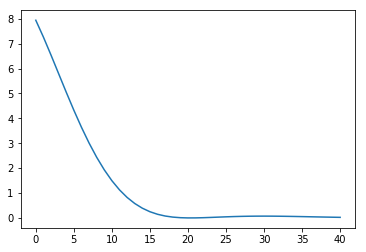

In [30]:
diameter = 11.E-9
# Phay's paper
I_max = from_mJ_by_um2(2E-2) # mJ/um2
K_max = K_from_I(I_max, diameter)
Ir_expected = Ir_sphere(K=K_max, diameter=diameter/1E-9)
plot(Ir_expected)

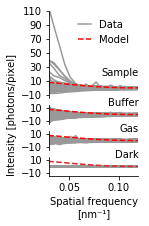

In [35]:
Np = 15000
Ns = 10

sf = 1.
fig = figure(figsize=(sf*2.25, sf*3))
f = 0.9
ax1 = fig.add_axes([0.30, 0.56, 0.55, f*0.45])
ax2 = fig.add_axes([0.30, 0.44, 0.55, f*0.1])
ax3 = fig.add_axes([0.30, 0.32, 0.55, f*0.1])
ax4 = fig.add_axes([0.30, 0.2, 0.55, f*0.1])

axs = [ax1, ax2, ax3, ax4]

clines = 0.6*np.ones(3)
lw = 1.5

#axs[0].set_title('Sample')
axs[0].text(0.12, 15, 'Sample', ha='right', va='bottom')#, color='C4')
tmp = (Ir_data_sample-Ir_bg_sample).swapaxes(0,1)
#tmp[tmp<0.01] = 0.01
axs[0].plot(spix*1E-9, tmp[:,0], ls='-', lw=lw, color=clines, alpha=1, label='Data');
axs[0].plot(spix*1E-9, Ir_expected, ls='--', lw=lw, color='r', alpha=1, label='Model');
axs[0].legend(frameon=False, loc='upper right', handlelength=4./3.)#, borderaxespad=None)
axs[0].plot(spix*1E-9, tmp[:,:Np], ls='-', lw=lw, color=clines, alpha=1);
axs[0].plot(spix*1E-9, Ir_expected, ls='--', lw=lw, color='r', alpha=1);

#axs[1].set_title('Buffer')
axs[1].text(0.12, 10, 'Buffer', ha='right', va='bottom')#, color='C4')
tmp = (Ir_data_buffer-Ir_bg_buffer).swapaxes(0,1)
#tmp[tmp<0.01] = 0.01
axs[1].plot(spix*1E-9, tmp[:,:Np], ls='-', lw=lw, color=clines, alpha=1);
#axs[1].plot(spix*1E-9, tmp[:,hs_buffer[sel_buffer].argsort()[::-1][:Ns]], ls='-', lw=1., color='C1');
axs[1].plot(spix*1E-9, Ir_expected, ls='--', lw=lw, color='r', alpha=1);

#axs[2].set_title('Gas')
axs[2].text(0.12, 10, 'Gas', ha='right', va='bottom')#, color='C4')
tmp = (Ir_data_bg-Ir_bg_bg).swapaxes(0,1)
#tmp[tmp<0.01] = 0.01
axs[2].plot(spix*1E-9, tmp[:,:Np], ls='-', lw=lw, color=clines, alpha=1);
#axs[2].plot(spix*1E-9, tmp[:,hs_bg[sel_bg].argsort()[::-1][:Ns]], ls='-', lw=1., color='C1');
axs[2].plot(spix*1E-9, Ir_expected, ls='--', lw=lw, color='r', alpha=1);

#axs[3].set_title('Dark')
axs[3].text(0.12, 10, 'Dark', ha='right', va='bottom')#, color='C4')
tmp = (Ir_data_dark-Ir_bg_dark).swapaxes(0,1)
#tmp[tmp<0.01] = 0.01
axs[3].plot(spix*1E-9, tmp[:,:Np], ls='-', lw=lw, color=clines, alpha=1);
#axs[3].plot(spix*1E-9, tmp[:,hs_dark[sel_dark].argsort()[::-1][:Ns]], ls='-', lw=1., color='C1');
axs[3].plot(spix*1E-9, Ir_expected, ls='--', lw=lw, color='C3', alpha=1);

for ax in axs:
    ax.set_xlim(0.03, 0.12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.set_yscale('log')
ax1.set_ylim(-15, 110)
ax1.set_yticks([-10, 10, 30, 50, 70, 90, 110])
for ax in axs[1:]:
    ax.set_ylim(-15, 15)
    ax.set_yticks([-10, 10])
    #ax.spines['left'].set_visible(False)
for ax in axs[:-1]:
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
ax2.set_ylabel('Intensity [photons/pixel]')
ax4.set_xlabel(u'Spatial frequency\n[nm⁻¹]')

fig.savefig('rubisco_traces.png', dpi=600)

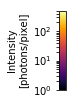

In [36]:
fig = plt.figure(figsize=(1., 1.1/0.8))
ax = fig.add_axes([0.8, 0.1, 0.1, 0.8])
matplotlib.colorbar.ColorbarBase(ax, cmap='inferno',
                                    norm=LogNorm(vmin=1, vmax=500),)
                                    #boundaries=[-10] + bounds + [10],
                                    #extend='both',
                                    # Make the length of each extension
                                    # the same as the length of the
                                    # interior colors:
                                    #extendfrac='auto',
                                    #ticks=bounds,
                                    #spacing='uniform',
                                    #orientation='horizontal')
ax.set_ylabel('Intensity\n[photons/pixel]')
ax.yaxis.set_label_position('left')
ax.yaxis.set_ticks_position('left')
fig.savefig('rubisco_cbar.png', dpi=600)


0.012685741447812975
0 20.40498051608756 4.11916791459


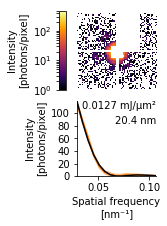

0.008515217518959057
1 17.779898444438015 1.50100725624


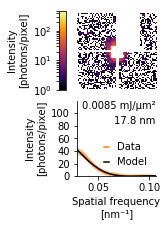

0.007452435290330155
2 18.208656551621214 1.31873123624


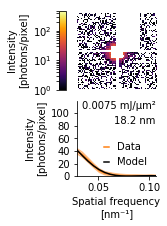

0.005571155210357403
3 18.751384654733243 1.14502728868


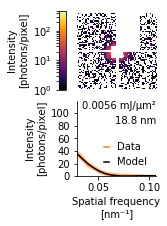

0.0042166874162017885
4 17.96005660739496 0.652990099667


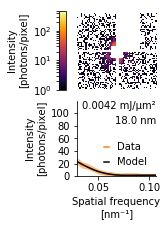

0.004088521989912611
5 15.894648999654343 0.271875452535


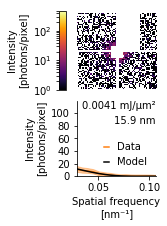

0.013032524215684606
6 11.603999695422935 0.516316031635


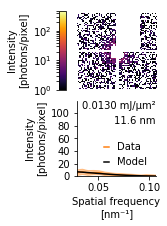

In [39]:
ds_fit_sample, Is_fit_sample, goods_fit_sample, ds_std_sample, Is_std_sample = fit_batch(data_sample[hs_sample.argsort()[::-1][:7]],
                                                                                         mask_sample[hs_sample.argsort()[::-1][:7]],
                                                                                         bg_sample,
                                                                                         do_plot=True)

0.00553882301963582
0 13.606058889177602 0.666369127359


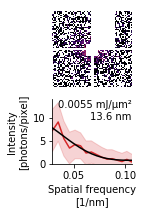

0.003573945513071851
1 15.575988498186058 0.691289383467


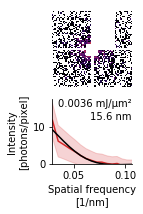

0.004629484347170403
2 13.883740604115173 0.215582790556


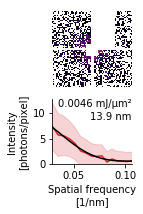

0.005540158885571177
3 13.85629362144264 0.353760903624


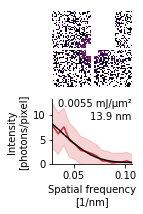

0.0027529736347312677
4 15.482976761620982 1.00515163266


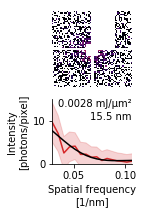

0.015151670939922738
5 11.083820668759124 0.708642412582


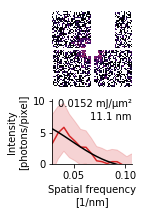

0.0017007268108243153
6 16.135372751949124 0.435391551385


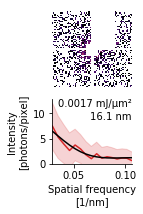

In [62]:
ds_fit_buffer, Is_fit_buffer, goods_fit_buffer, ds_std_buffer, Is_std_buffer = fit_batch(data_buffer[hs_buffer.argsort()[::-1][:7]],
                                                                                         mask_buffer[hs_buffer.argsort()[::-1][:7]],
                                                                                         bg_buffer,
                                                                                         do_plot=True)

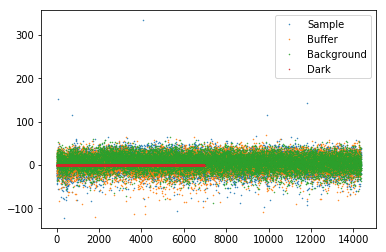

In [1178]:
tmp = (Ir_data_sample-Ir_bg_sample).sum(axis=1)
plot(tmp, '.', label='Sample', ms=1.)
tmp = (Ir_data_buffer-Ir_bg_buffer).sum(axis=1)
plot(tmp, '.', label='Buffer', ms=1.)
tmp = (Ir_data_bg-Ir_bg_bg).sum(axis=1)
plot(tmp, '.', label='Background', ms=1.)
tmp = (Ir_data_dark-Ir_bg_dark).sum(axis=1)
plot(tmp, '.', label='Dark', ms=1.)
legend()

6291.0
4862.0
4558.0
2103.0


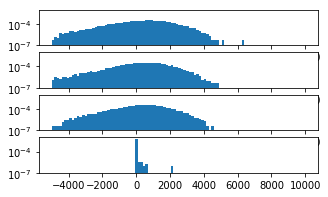

In [1200]:
fig, axs = subplots(4, 1, figsize=(5, 3))

tmp = ((data_sample-bg_sample)*mask0).sum(axis=1).sum(axis=1)
print(tmp.max())
axs[0].hist(tmp, 100, range=(-5000, 10000), label='Sample',normed=True)

tmp = ((data_buffer-bg_buffer)*mask0).sum(axis=1).sum(axis=1)
print(tmp.max())
axs[1].hist(tmp, 100, range=(-5000, 10000), label='Buffer',normed=True)

tmp = ((data_bg-bg_bg)*mask0).sum(axis=1).sum(axis=1)
print(tmp.max())
axs[2].hist(tmp, 100, range=(-5000, 10000), label='Background',normed=True)

tmp = ((data_dark-bg_dark)*mask0).sum(axis=1).sum(axis=1)
print(tmp.max())
axs[3].hist(tmp, 100, range=(-5000, 10000), label='Dark',normed=True)

for ax in axs:
    ax.set_yscale('log')
    ax.set_ylim(1E-7, 1E-2)
    #legend()

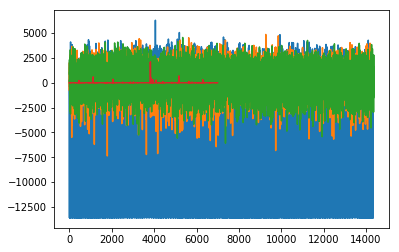

In [1125]:
tmp = (data_sample-bg_sample)[sel_buffer][:,mask0].sum(axis=1)
plot(tmp)
tmp = (data_buffer-bg_buffer)[sel_buffer][:,mask0].sum(axis=1)
plot(tmp)
tmp = (data_bg-bg_bg)[sel_bg][:,mask0].sum(axis=1)
plot(tmp)
tmp = (data_dark-bg_dark)[:,mask0].sum(axis=1)
plot(tmp)


In [980]:
#for i in range(100):
#    figure()
#    imshow((data_sample[nph_sample.argsort()[::-1][i]]-bg_sample)*mask0, vmin=0, vmax=10)

3
18.208656672305928


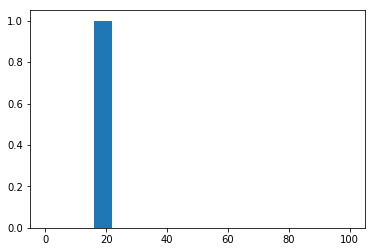

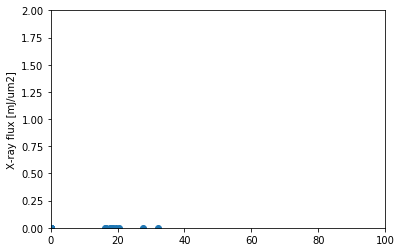

In [1014]:
plot_hist(ds_fit_sample, Is_fit_sample, goods_fit_sample, ds_std_sample, Is_std_sample)

Do same fitting with buffer data

In [601]:
Ir_data_buffer, Ir_bg_buffer, Ir_std_buffer = calculate_rmeans(data_buffer, mask_buffer, bg_buffer, gmd_buffer)

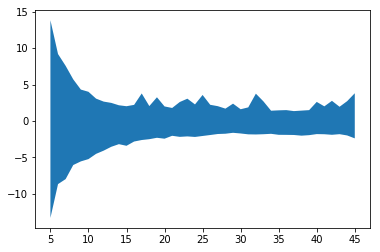

In [602]:
fill_between(rpix, (Ir_data_buffer-Ir_bg_buffer).min(axis=0), (Ir_data_buffer-Ir_bg_buffer).max(axis=0))

13.383398696666854 0.362123564246


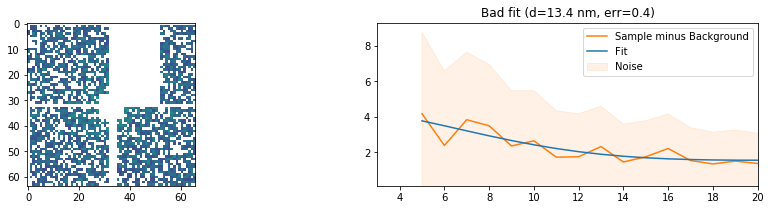

13.606059446203764 0.666369127359


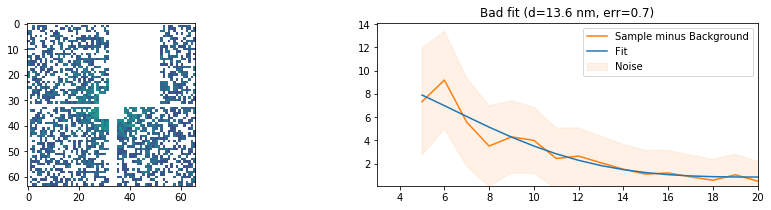

30.703911777666605 0.507063407964


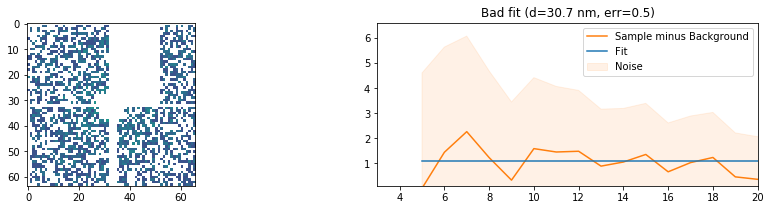

15.120721554773173 0.775127950225


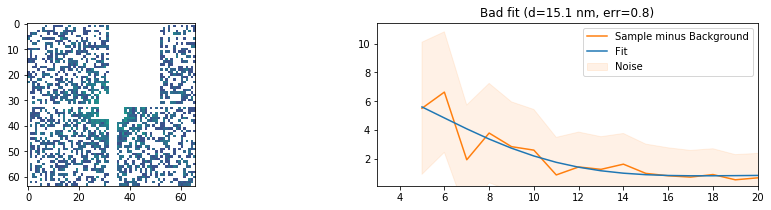

12.928491384944746 0.742436475274


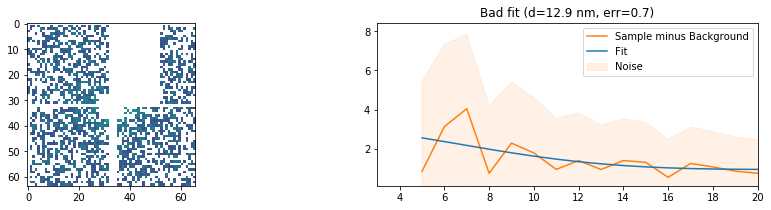

30.76238908113076 0.603432548171


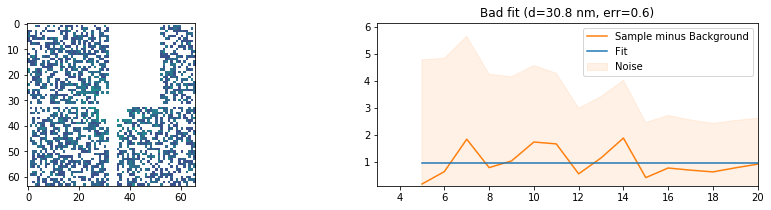

36.49719844387337 0.454029770492


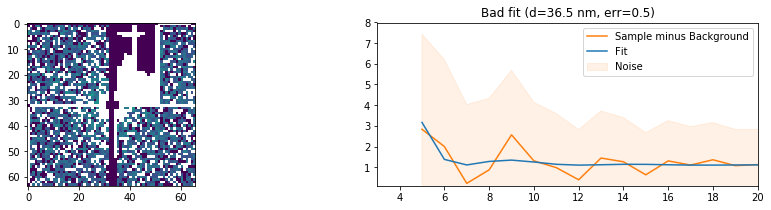

9.961207687581112 0.460394294338


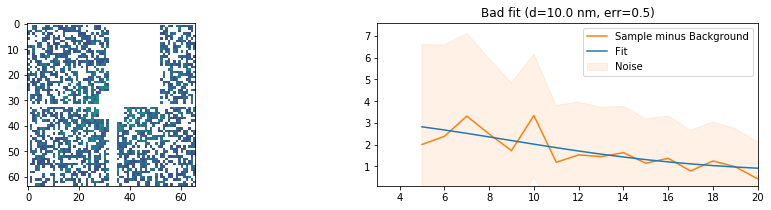

17.230635163093222 0.555606278297


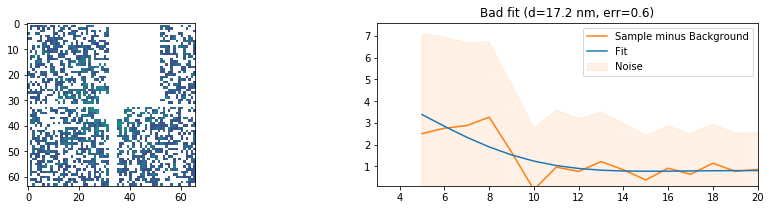

16.74845459572164 0.548708281779


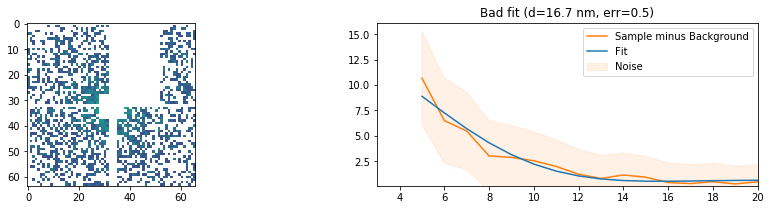

In [636]:
ds_fit_buffer, Is_fit_buffer, errs_fit_buffer, ds_std_buffer, Is_std_buffer = fit_batch(data_buffer, mask_buffer, bg_buffer, do_plot=True)

0
nan


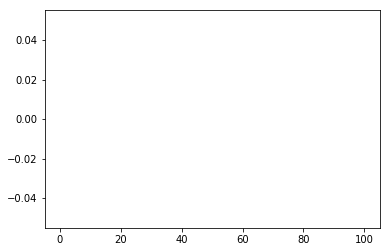

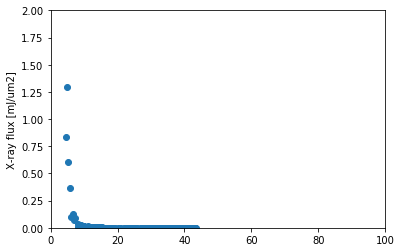

In [637]:
plot_hist(ds_fit_buffer, Is_fit_buffer, errs_fit_buffer, ds_std_buffer, Is_std_buffer)

Do same fitting with background data

In [638]:
Ir_data_bg, Ir_bg_bg, Ir_std_bg = calculate_rmeans(data_bg, mask_bg, bg_bg, gmd_bg)

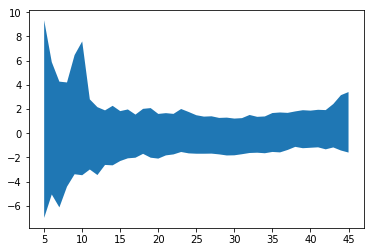

In [639]:
fill_between(rpix, (Ir_data_bg-Ir_bg_bg).min(axis=0), (Ir_data_bg-Ir_bg_bg).max(axis=0))

31.432853975752153 1.3367682427


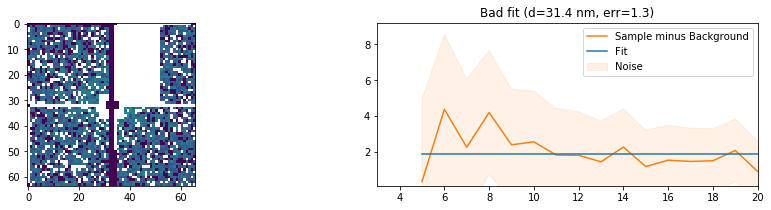

12.543834896256568 0.211691101671


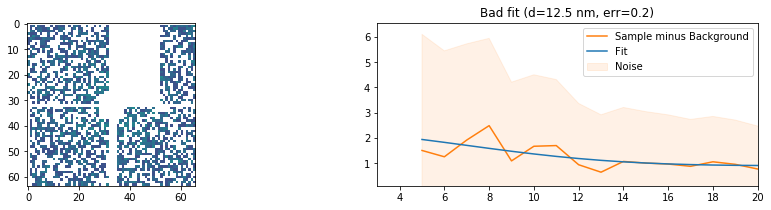

15.491877912373797 0.36281390073


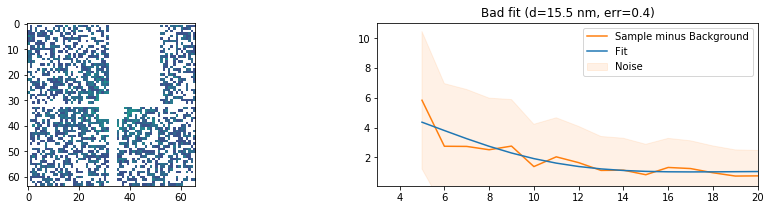

30.695971961521423 0.304093823069


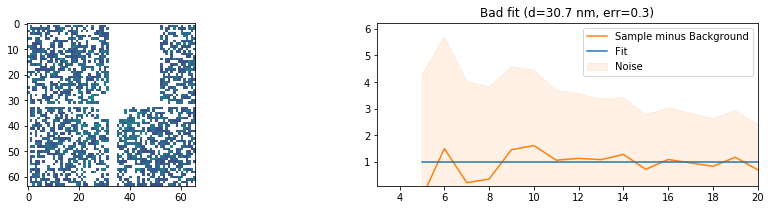

14.280317252401087 0.282000602357


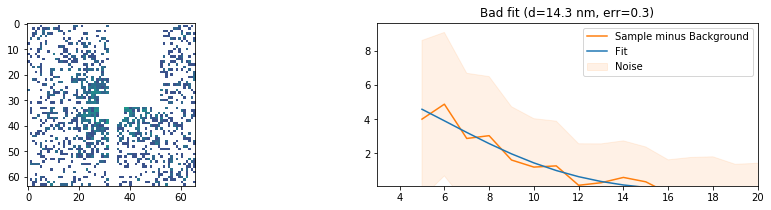

36.19660370053016 0.20766583519


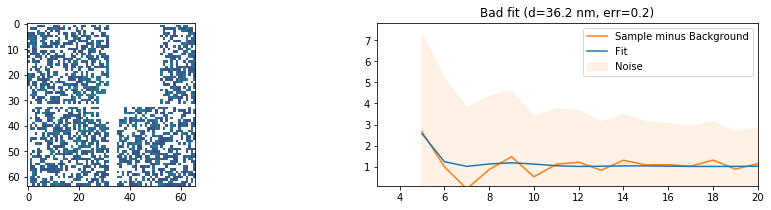

30.71379902460553 0.536096079621


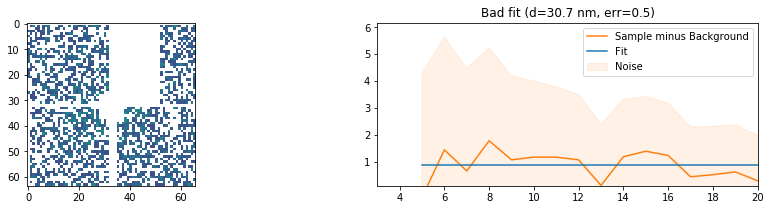

12.155288589323808 0.0842389730703


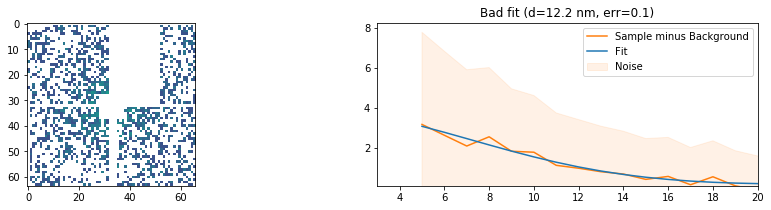

11.498810498556308 0.226783771546


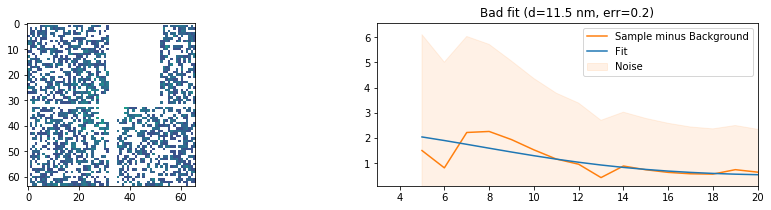

30.516689455594296 0.255686276437


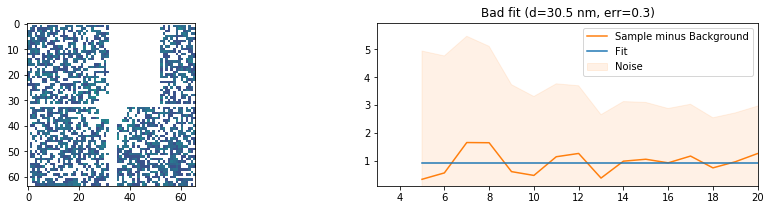

In [640]:
ds_fit_bg, Is_fit_bg, goods_fit_bg, ds_std_bg, Is_std_bg = fit_batch(data_bg, mask_bg, bg_bg, do_plot=True)

0
nan


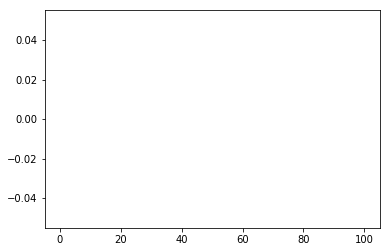

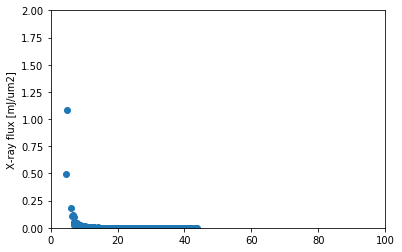

In [641]:
plot_hist(ds_fit_bg, Is_fit_bg, goods_fit_bg, ds_std_buffer, Is_std_buffer)

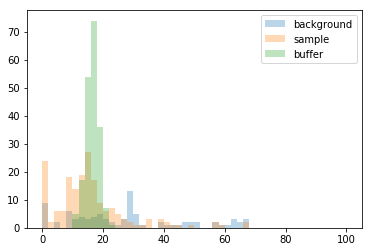

In [47]:
hist(ds_fit_bg[errs_fit_bg<200.], 50, range=(0, 100), alpha=0.3, label='background')
hist(ds_fit_sample[errs_fit_sample<200.], 50, range=(0, 100), alpha=0.3, label='sample')
hist(ds_fit_buffer[errs_fit_buffer<200.], 50, range=(0, 100), alpha=0.3, label='buffer')
legend()

In [ ]:
# Sanity:
# Intensities? What order of magnitude?
# Add buffer run?
# Error metric
# Try: Scale background by fitting parameter (maybe only refinement)